# Spotify Song Prediction

##### Dependencies

In [230]:
# Ucitavanje biblioteka i funkcija
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

##### Loading the dataset

In [231]:
df = pd.read_csv('spotify_songs.csv')
df.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


##### Dropping invalid and missing values

In [232]:
df = df[df['track_popularity'] > 0]
# df['track_popularity'] = (df['track_popularity'] - df['track_popularity'].min()) / (df['track_popularity'].max() - df['track_popularity'].min())
columns_to_drop = ['track_id', 'track_artist', 'track_name', 'track_album_id', 'track_album_name', 'playlist_name', 'playlist_id']
df.drop(columns=columns_to_drop, inplace=True)
df.dropna(axis=0, inplace=True)

rows_to_drop = df.loc[df['duration_ms'] < 20000].index
df.drop(rows_to_drop, inplace=True)

new_df = df.copy()

# Assuming 'date' is a string column in the format 'YYYY-MM-DD'
new_df[['year', 'month', 'day']] = new_df['track_album_release_date'].str.split('-', expand=True)

# Convert the columns to numeric (to handle missing values during median calculation)
new_df['year'] = pd.to_numeric(new_df['year'], errors='coerce', downcast='integer')
# new_df['month'] = pd.to_numeric(new_df['month'], errors='coerce', downcast='integer')
# new_df['day'] = pd.to_numeric(new_df['day'], errors='coerce', downcast='integer')

# Calculate median values for year, month, and day
median_year = int(new_df['year'].median())
# median_month = int(new_df['month'].median())
# median_day = int(new_df['day'].median())

# Fill missing values with median values
new_df['year'] = new_df['year'].fillna(median_year).astype(int)
# new_df['month'] = new_df['month'].fillna(median_month).astype(int)
# new_df['day'] = new_df['day'].fillna(median_day).astype(int)

X = new_df.drop(['track_popularity', 'track_album_release_date'], axis=1)
X = pd.get_dummies(X, dtype=int)
y = new_df['track_popularity']


In [233]:
# X.tail()
X.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'year', 'playlist_genre_edm', 'playlist_genre_latin',
       'playlist_genre_pop', 'playlist_genre_r&b', 'playlist_genre_rap',
       'playlist_genre_rock', 'playlist_subgenre_album rock',
       'playlist_subgenre_big room', 'playlist_subgenre_classic rock',
       'playlist_subgenre_dance pop', 'playlist_subgenre_electro house',
       'playlist_subgenre_electropop', 'playlist_subgenre_gangster rap',
       'playlist_subgenre_hard rock', 'playlist_subgenre_hip hop',
       'playlist_subgenre_hip pop', 'playlist_subgenre_indie poptimism',
       'playlist_subgenre_latin hip hop', 'playlist_subgenre_latin pop',
       'playlist_subgenre_neo soul', 'playlist_subgenre_new jack swing',
       'playlist_subgenre_permanent wave', 'playlist_subgenre_pop edm',
       'playlist_subgenre_post-teen pop',
       'playlist_subge

In [234]:
# df.iloc[3446]
# X.iloc[3446]

##### Splitting the dataset

In [235]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

(array([1523.,  822.,  702.,  817.,  862.,  906., 1051., 1296., 1629.,
        1863., 1806., 1896., 2015., 1975., 2025., 1869., 1796., 1600.,
        1350.,  987.,  598.,  404.,  171.,  103.,   64.]),
 array([  1.  ,   4.96,   8.92,  12.88,  16.84,  20.8 ,  24.76,  28.72,
         32.68,  36.64,  40.6 ,  44.56,  48.52,  52.48,  56.44,  60.4 ,
         64.36,  68.32,  72.28,  76.24,  80.2 ,  84.16,  88.12,  92.08,
         96.04, 100.  ]),
 <BarContainer object of 25 artists>)

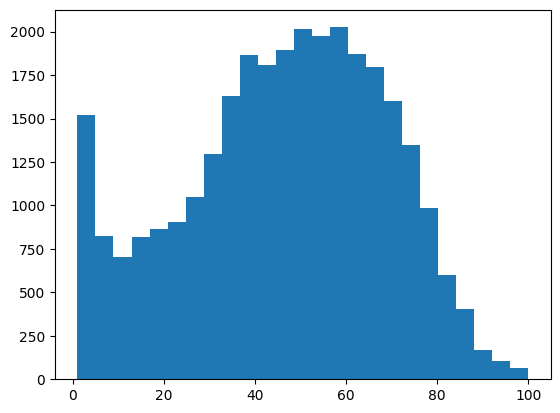

In [236]:
plt.hist(y, bins=25)

In [237]:
X.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
count,30130.000000,30130.000000,30130.000000,30130.000000,30130.000000,30130.000000,30130.000000,30130.000000,30130.000000,30130.000000,...,30130.000000,30130.000000,30130.000000,30130.000000,30130.000000,30130.000000,30130.000000,30130.000000,30130.000000,30130.000000
mean,0.656072,0.694330,5.356986,-6.723034,0.566578,0.106867,0.179652,0.080745,0.188097,0.510071,...,0.029771,0.027016,0.026253,0.030601,0.027614,0.031530,0.025689,0.024992,0.023299,0.017026
std,0.145054,0.180924,3.612914,2.978582,0.495556,0.101107,0.221496,0.219575,0.151531,0.232221,...,0.169958,0.162133,0.159889,0.172236,0.163866,0.174748,0.158207,0.156102,0.150854,0.129371
min,0.077100,0.000175,0.000000,-46.448000,0.000000,0.022400,0.000001,0.000000,0.009360,0.000010,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.564000,0.577000,2.000000,-8.164000,0.000000,0.040900,0.016500,0.000000,0.092700,0.331000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.673000,0.716000,6.000000,-6.173500,1.000000,0.062400,0.084800,0.000014,0.126000,0.511000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.762000,0.836000,9.000000,-4.660000,1.000000,0.132000,0.263000,0.003958,0.244000,0.692000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.983000,1.000000,11.000000,1.275000,1.000000,0.918000,0.994000,0.994000,0.996000,0.991000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [238]:
print(X.columns)

numeric_feats = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
dummy_feats = [feat for feat in X.columns if feat not in numeric_feats]

print(X[numeric_feats])

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'year', 'playlist_genre_edm', 'playlist_genre_latin',
       'playlist_genre_pop', 'playlist_genre_r&b', 'playlist_genre_rap',
       'playlist_genre_rock', 'playlist_subgenre_album rock',
       'playlist_subgenre_big room', 'playlist_subgenre_classic rock',
       'playlist_subgenre_dance pop', 'playlist_subgenre_electro house',
       'playlist_subgenre_electropop', 'playlist_subgenre_gangster rap',
       'playlist_subgenre_hard rock', 'playlist_subgenre_hip hop',
       'playlist_subgenre_hip pop', 'playlist_subgenre_indie poptimism',
       'playlist_subgenre_latin hip hop', 'playlist_subgenre_latin pop',
       'playlist_subgenre_neo soul', 'playlist_subgenre_new jack swing',
       'playlist_subgenre_permanent wave', 'playlist_subgenre_pop edm',
       'playlist_subgenre_post-teen pop',
       'playlist_subge

<Axes: >

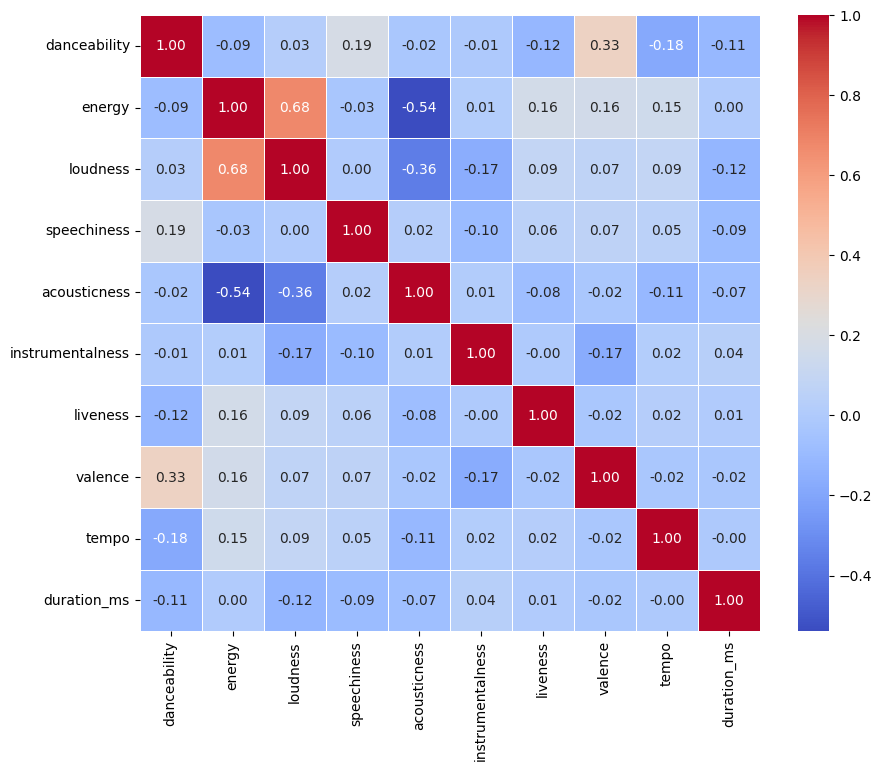

In [239]:
numeric_values = df[numeric_feats]
correlation_matrix = numeric_values.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

In [240]:
def model_evaluation(y_test, y_predicted, N, d):
    mse = mean_squared_error(y_test, y_predicted)
    mae = mean_absolute_error(y_test, y_predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_predicted)
    r2_adj = 1 - ((1 - r2) * (N - 1)) / (N - d - 1)

    # printing values
    print('Mean squared error: ', mse)
    print('Mean absolute error: ', mae)
    print('Root mean squared error: ', rmse)
    print('R2 score: ', r2)
    print('R2 adjusted score: ', r2_adj)

    # Uporedni prikaz nekoliko pravih i predvidjenih vrednosti
    res = pd.concat([pd.DataFrame(y_test.values),
                    pd.DataFrame(y_predicted)], axis=1)
    res.columns = ['y', 'y_pred']
    print(res.head(20))
    return mse, mae, rmse, r2, r2_adj

##### Scaling the data

In [241]:
s = StandardScaler()
s.fit(X_train[numeric_feats])
X_train_std = s.transform(X_train[numeric_feats])
X_test_std = s.transform(X_test[numeric_feats])
X_train_std = pd.DataFrame(X_train_std)
X_test_std = pd.DataFrame(X_test_std)


X_train_std = pd.concat([X_train_std, X_train[dummy_feats].reset_index(drop=True)], axis=1)
X_test_std = pd.concat([X_test_std, X_test[dummy_feats].reset_index(drop=True)], axis=1)

X_train_std.columns = list(X.columns)
X_test_std.columns = list(X.columns)
X_train_std.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,-0.613069,0.944275,0.537293,0.318153,-0.754129,-0.367289,-0.881647,1.411008,2.484889,0.342183,...,0,0,0,0,0,0,0,0,0,0
1,0.296288,-1.062129,-1.944799,-0.782517,-0.537653,-0.213644,0.850574,0.713198,-0.575310,-0.039694,...,0,0,0,0,0,0,0,0,0,0
2,-1.005746,0.363910,-0.089853,-0.650873,-0.143939,-0.314402,-0.776024,0.170456,-0.073521,-0.905830,...,0,0,0,0,0,0,0,0,0,0
3,0.289399,1.110093,1.020900,-0.057976,-0.776949,-0.287503,0.190429,-1.160551,0.193486,-0.878681,...,0,0,0,0,0,0,0,0,0,0
4,0.110284,0.667911,0.363570,-0.482605,-0.719854,3.252717,-0.752259,1.703915,-0.030345,-1.566455,...,0,0,0,0,0,0,0,0,0,0


In [242]:
# lr = LinearRegression()
# folds = KFold(n_splits=5, shuffle=True, random_state=42)

# hyper_params = [{'n_features_to_select': list(range(1, 16))}]

# lm = LinearRegression()
# lm.fit(X_train, y_train)
# rfe = RFE(lm)

# model_cv = GridSearchCV(
#     estimator=rfe,
#     param_grid=hyper_params,
#     scoring='r2',
#     cv=folds,
#     verbose=1,
#     return_train_score=True
# )

# model_cv.fit(X_train, y_train)

In [243]:
# cv_results = pd.DataFrame(model_cv.cv_results_)
# cv_results

In [244]:
# # plotting cv results
# plt.figure(figsize=(16,6))

# plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
# plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
# plt.xlabel('number of features')
# plt.ylabel('r-squared')
# plt.title("Optimal Number of Features")
# plt.legend(['test score', 'train score'], loc='upper left')

Optimal number of features is 13

In [245]:
# final model
n_features_optimal = 13

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = lm.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(r2)

#model_evaluation(y_test, y_pred, X_train.shape[0], X_train.shape[1])


0.1722575241453541


In [246]:
def standardizacija(x_train, x_test, numeric_feats, dummy_feats):
    # Save the original order of columns
    cols = x_train.columns
    
    # Standardize numeric features
    s = StandardScaler()
    s.fit(x_train[numeric_feats])
    
    x_train_std_numeric = s.transform(x_train[numeric_feats])
    x_test_std_numeric = s.transform(x_test[numeric_feats])
    
    x_train_std_numeric = pd.DataFrame(x_train_std_numeric, columns=numeric_feats)
    x_test_std_numeric = pd.DataFrame(x_test_std_numeric, columns=numeric_feats)

    # Concatenate standardized numeric features with dummy features
    x_train_std = pd.concat([x_train_std_numeric, x_train[dummy_feats]], axis=1)
    x_test_std = pd.concat([x_test_std_numeric, x_test[dummy_feats]], axis=1)

    return x_train_std_numeric, x_test_std_numeric

## Lasso with poly features

In [247]:
from sklearn.model_selection import train_test_split

In [248]:
# podela skupa na trening i test podatke

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
# x_train, x_val, y_train, y_val = train_test_split(x_train_1, y_train_1, test_size=0.05, random_state=42)

x_train_std, x_val_std = standardizacija(x_train, x_train, numeric_feats, dummy_feats)

# x_train_std = x = x_train_std[['playlist_genre', 'month', 'danceability']]
# x_val_std = x = x_val_std[['playlist_genre', 'month', 'danceability']]


In [249]:
poly = PolynomialFeatures(interaction_only=False, degree=2, include_bias=True)
x_inter_train = poly.fit_transform(x_train)
x_inter_test = poly.transform(x_test)
out_feat_names = PolynomialFeatures.get_feature_names_out(poly,input_features=None)

/home/personal/Desktop/faks/MU/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.844e+06, tolerance: 1.442e+03
  model = cd_fast.enet_coordinate_descent(


Mean squared error:  398.10359372885625
Mean absolute error:  16.11253383952706
Root mean squared error:  19.952533516545117
R2 score:  0.2053622327083856
R2 adjusted score:  0.08267636624100239
     y     y_pred
0   36  46.578733
1   40  48.130880
2    6  33.577585
3   39  54.174202
4   90  64.595279
5    6  38.095619
6   51  45.432908
7   49  53.648170
8   74  48.485334
9   76  61.771681
10  51  51.965968
11  76  58.156595
12   2  49.127488
13  59  52.567951
14  40  44.838450
15  60  45.192175
16  43  43.999683
17  39  53.652889
18  45  40.170491
19  48  36.146411
koeficijenti:  [ 0. -0.  0. ...  0.  0. -0.]


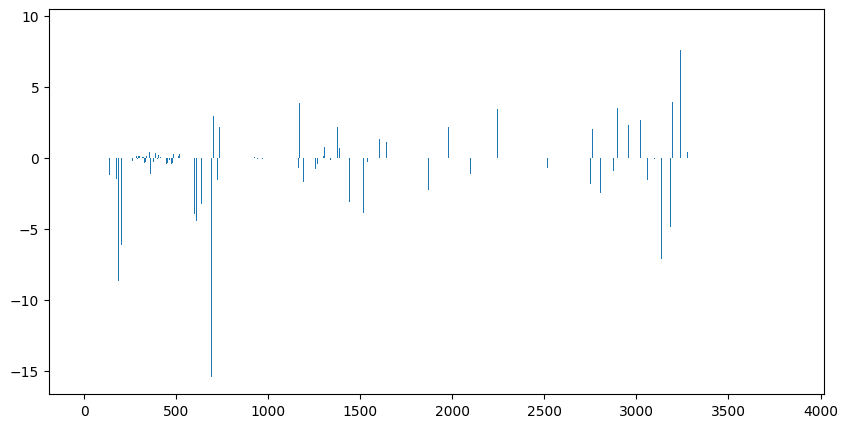

In [250]:
# Inicijalizacija modela
lasso_model_2 = Lasso(alpha=0.01)

#Obuka
lasso_model_2.fit(x_inter_train, y_train)

# Testiranje
y_predicted = lasso_model_2.predict(x_inter_test)

# Evaluacija (racunanje mera uspesnosti)
model_evaluation(y_test, y_predicted, x_inter_train.shape[0], x_inter_train.shape[1])

# Ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(lasso_model_2.coef_)),lasso_model_2.coef_)
print("koeficijenti: ", lasso_model_2.coef_)

(array([575.,   0.,   0., 387.,   0.,   0., 321.,   0.,   0., 240.,   0.,
          0., 240.,   0.,   0., 192.,   0.,   0., 189.,   0.,   0., 201.,
          0.,   0., 195.,   0.,   0., 174.,   0.,   0., 172.,   0.,   0.,
        161.,   0.,   0., 207.,   0.,   0., 201.,   0.,   0., 190.,   0.,
          0., 219.,   0.,   0., 206.,   0.,   0., 242.,   0.,   0., 205.,
          0.,   0., 209.,   0.,   0., 228.,   0.,   0., 207.,   0.,   0.,
        228.,   0.,   0., 243.,   0.,   0., 242.,   0.,   0.,   0., 272.,
          0.,   0., 271.,   0.,   0., 266.,   0.,   0., 277.,   0.,   0.,
        345.,   0.,   0., 323.,   0.,   0., 351.,   0.,   0., 377.,   0.,
          0., 388.,   0.,   0., 433.,   0.,   0., 431.,   0.,   0., 435.,
          0.,   0., 483.,   0.,   0., 459.,   0.,   0., 486.,   0.,   0.,
        442.,   0.,   0., 428.,   0.,   0., 464.,   0.,   0., 472.,   0.,
          0., 505.,   0.,   0., 430.,   0.,   0., 496.,   0.,   0., 465.,
          0.,   0., 497.,   0.,   0., 

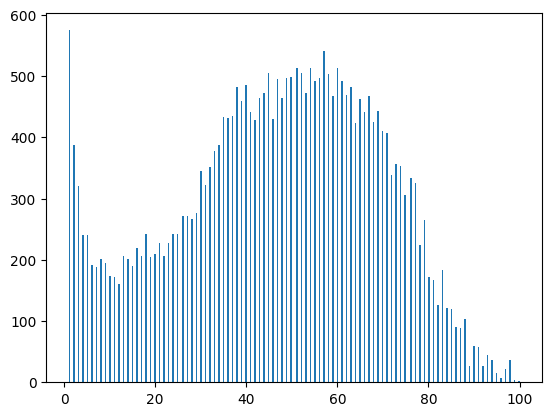

In [251]:
plt.hist(y, bins=len(y)//100)